Autores:
- Alejandro Pastor Membrado
- Ángel Romero Huici

# Librerías

Importamos las librerías necesarias para procesar imágenes, extraer características y gestionar índices de búsqueda con FAISS. También configura el entorno para evitar conflictos de librerías con OpenMP.

In [16]:
import glob
import os
from collections import Counter

import cv2
import faiss
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.models as models
from PIL import Image
from faiss import read_index, write_index
from skimage.io import imread_collection
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import inception_v3

#Soluciona un posible problema relacionado con duplicados de bibliotecas en sistemas que usan OpenMP
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" 

# Conjunto de imágenes

El conjunto original de imágenes se ha obtenido de https://www.kaggle.com/datasets/elkamel/corel-images?resource=download y consta de 1000 imágenes organizadas en 10 clases. De estas, se utilizarán 900 imágenes para entrenamiento (90 por clase) para extraer las características del sistema, y las 100 restantes (10 por clase) se destinarán a pruebas para evaluar el rendimiento del modelo.

## Creación de directorios

A continuación, se procesan y almacenan las imágenes obtenidas del conjunto de datos descargado de Kaggle en dos directorios separados. Las 900 imágenes de entrenamiento se guardan en la carpeta images y se utilizan para extraer las características que conformarán la base de datos del modelo. Por otro lado, las imágenes de prueba se almacenan en la carpeta queries y se emplean para evaluar el rendimiento del modelo.

Base de datos de imágenes (images)

In [17]:
col_dir = 'dataset/training_set/**/*.jpg'
image_paths = glob.glob(col_dir, recursive=True)

#El código únicamente se ejecuta si la carpeta images no existe
if not os.path.exists('images'):
    os.mkdir('images')
    col = imread_collection(image_paths)
    for i in range(len(col)):
        im = Image.fromarray(col[i])
        im.save(f"images/{i}.jpg")
    print("Imágenes almacenadas en la carpeta images.")
else:
    print("La carpeta images ya existe. No se realizaron cambios.")

La carpeta images ya existe. No se realizaron cambios.


Imágenes de búsqueda (queries)

In [18]:
col_test_dir = 'dataset/test_set/**/*.jpg'
test_image_paths = glob.glob(col_test_dir, recursive=True)

#El código únicamente se ejecuta si la carpeta queries no existe
if not os.path.exists('queries'):
    os.mkdir('queries')
    col_test = imread_collection(test_image_paths)
    for i in range(len(col_test)):
        im = Image.fromarray(col_test[i])
        im.save(f"queries/{i}.jpg")
    print("Imágenes de prueba almacenadas en la carpeta queries.")
else:
    print("La carpeta queries ya existe. No se realizaron cambios.")

La carpeta queries ya existe. No se realizaron cambios.


## Lectura de imágenes

Se cargan las imágenes almacenadas en el paso anterior y se guardan en una variable de tipo ImageCollection de skimage, un tipo de objeto diseñado para gestionar y manipular conjuntos de imágenes.

In [19]:
col_dir = 'images/*.jpg'
image_paths = glob.glob(col_dir, recursive=True)
col = imread_collection(image_paths)

print(f"Cantidad de imágenes base de datos: {len(col)}")

Cantidad de imágenes base de datos: 900


In [20]:
col_test_dir = 'queries/*.jpg'
test_image_paths = glob.glob(col_test_dir, recursive=True)
col_test = imread_collection(test_image_paths)

print(f"Cantidad de imágenes queries: {len(col_test)}")

Cantidad de imágenes queries: 100


# Preparación

## Carga de modelos

Se cargan y configuran tres modelos de redes neuronales preentrenados de PyTorch para su uso como extractores de características de imágenes. Todos los modelos han sido entrenados previamente con pesos de ImageNet, y el procedimiento es similar en cada caso: se elimina o desactiva la última capa, que se utilizaría para tareas de clasificación, permitiendo que el modelo devuelva únicamente las características extraídas. Los modelos utilizados son:
* ResNet-152
* EfficientNet
* Inception V3

En el caso de ResNet-152 y EfficientNet, se elimina la última capa y se desactiva el ajuste de pesos para asegurar que solo se extraigan características. En el caso de Inception V3, la capa de clasificación se reemplaza por una capa de identidad y el modelo se coloca en modo de evaluación para asegurar un funcionamiento correcto durante la extracción de características.

In [21]:
#Resnet152
resnet152 = models.resnet152(pretrained=True)
modules=list(resnet152.children())[:-1]
resnet152=nn.Sequential(*modules)
for p in resnet152.parameters():
    p.requires_grad = False
    
#Efficientnet
efficientnet = models.efficientnet_b0(pretrained=True)
modules = list(efficientnet.children())[:-1]
efficientnet_model = nn.Sequential(*modules)
for p in efficientnet_model.parameters():
    p.requires_grad = False
    
#Inception_v3
inception = inception_v3(pretrained=True, transform_input=False)
inception.fc = nn.Identity()
inception.eval();

c:\Users\aleja\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\aleja\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\aleja\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0

## Funciones extractores

Se definen las funciones de extracción de características usando varios métodos diferentes: cálculo del histograma, extracción de descriptores SIFT y uso de los modelos de redes neuronales preentrenados ResNet152, EfficientNetB0 e InceptionV3.

In [22]:
def histo(img):
    """Convierte la imagen en una matriz plana y calcula un histograma para el rango de valores [0, 256].
    Se devuelve como un array de numpy"""
    return np.array([np.histogram(np.asarray(img).ravel(),256,[0,256])[0]]).astype('float32')

def sift(img):
    """Se inicializa un array de 0s con capacidad para almacenar hasta 128 descriptores. 
    La imagen se convierte a escala de grises  y los descriptores se obtienen 
    utilizando el operador SIFT previamente definido. 
    Finalmente, los descriptores generados se almacenan en el array y se devuelven."""
    xa = np.zeros((1,128)).astype('float32')
    sift = cv2.SIFT_create(nfeatures=128)
    gray = cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2GRAY)
    _, descriptors = sift.detectAndCompute(gray, mask=None) 
    a = descriptors[0] 
    xa[0,:a.size] = a
    return xa

def resnet(img):
    """Durante el preprocesado de la imagen, se redimensiona a 256px, se recorta el centro (224px), se convierte
    a tensor y se normaliza. Se pasa la imagen al modelo ResNet y se obtiene la salida de 2048 dimensiones.
    Este resultado se almacena en un array de numpy y se devuelve."""
    preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    input_image = img
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)
    features = resnet152(input_batch).numpy()[0,:,0,0]

    a = np.zeros((1,2048)).astype('float32')
    a[0,:] = features
    return a

def efficientnet(img):
    """Durante el preprocesado de la imagen, se redimensiona a 600px, se convierte
    a tensor y se normaliza. Se pasa la imagen al modelo EfficientNet, sin modificar los gradientes,
    y se obtiene la salida de 1028 dimensiones.
    A este resultado se le aplica otra normalización, se almacena en un array de numpy y se devuelve."""
    preprocess = transforms.Compose([
        transforms.Resize(600),
        transforms.CenterCrop(600),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    input_image = img
    input_tensor = preprocess(input_image).unsqueeze(0)

    with torch.no_grad():
        features = efficientnet_model(input_tensor).cpu().numpy()[0, :, 0, 0]
    features = features / np.linalg.norm(features)

    a = np.zeros((1, 1280), dtype="float32")
    a[0, :] = features
    return a

def inception_v3(img):
    """Durante el preprocesado de la imagen, se redimensiona a 299px, se convierte
    a tensor y se normaliza. Se pasa la imagen al modelo InceptionV3, sin modificar los gradientes,
    y se obtiene la salida de 2048 dimensiones.
    A este resultado se le aplica otra normalización, se almacena en un array de numpy y se devuelve."""
    preprocess = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_image = img
    input_tensor = preprocess(input_image).unsqueeze(0)
    with torch.no_grad():
        features = inception(input_tensor).cpu().numpy()[0, :]
    features = features / np.linalg.norm(features)

    a = np.zeros((1, 2048), dtype="float32")
    a[0, :] = features
    return a

## Funciones de evaluación

Se definen las funciones necesarias para poder obtener el accuracy del modelo con cada uno de los extractores. Esto permitirá llegar a una conclusión acerca de cual es el que mejor se adapta al problema planteado.

In [23]:
#Se definen diccionarios para agrupar índices según las clases a las que pertenecen.
training_classes = {
    'beaches' : list(range(0,90)),
    'bus' : list(range(90,180)),
    'dinosaurs' : list(range(180,270)),
    'elephants' : list(range(270,360)),
    'flowers' : list(range(360,450)),
    'foods' : list(range(450,540)),
    'horses' : list(range(540,630)),
    'monuments' : list(range(630,720)),
    'mountains_and_snow' : list(range(720,810)),
    'people_and_villages_in_Africa' : list(range(810,900)),
}

test_classes = {
    'beaches' : list(range(0,10)),
    'bus' : list(range(10,20)),
    'dinosaurs' : list(range(20,30)),
    'elephants' : list(range(30,40)),
    'flowers' : list(range(40,50)),
    'foods' : list(range(50,60)),
    'horses' : list(range(60,70)),
    'monuments' : list(range(70,80)),
    'mountains_and_snow' : list(range(80,90)),
    'people_and_villages_in_Africa' : list(range(90,100)),
}


# funciones auxiliares
def get_training_class_name(number):
    """Devuelve el nombre de la clase de entrenamiento asociada a un índice."""
    for class_name, numbers in training_classes.items():
        if number in numbers:
            return class_name
    return None

def get_test_class_name(number):
    """Devuelve el nombre de la clase de test asociada a un índice."""
    for class_name, numbers in test_classes.items():
        if number in numbers:
            return class_name
    return None
        

def get_result_classes(I):
    """Analiza las clases asociadas a los índices devueltos por una búsqueda. 
    Calcula un score relativo para cada clase, basado en su frecuencia respecto al total de clases identificadas."""
    match_classes = [get_training_class_name(i) for i in I]
    a = Counter(match_classes)
    scores = {}
    for k in a.keys():
        scores[k] = a[k]/len(match_classes)
    return scores
    

# funciones score
def get_extractor_consistency(index_path,k):
    """Evalúa la consistencia de un extractor de características con base en la diversidad de clases en 
    los resultados de búsqueda."""
    index = read_index(index_path)
    consistencies = []
    for i in range(0,len(col_test)):
        if index_path == 'ext_1.index':
            a = histo(Image.open(f"queries/{i}.jpg"))
        
        elif index_path == 'ext_2.index':
            a = sift(Image.open(f"queries/{i}.jpg"))

        elif index_path == 'ext_3.index':
            a = resnet(Image.open(f"queries/{i}.jpg"))
        elif index_path == 'ext_4.index':
            a = efficientnet(Image.open(f"queries/{i}.jpg"))
        elif index_path == 'ext_5.index':
            a = inception_v3(Image.open(f"queries/{i}.jpg"))
        else:
            a = None
        D, I = index.search(a, k)  # Realizar la búsqueda
        result_classes = get_result_classes(I[0])
        consistencies.append(1/len(result_classes.keys()))
    return sum(consistencies) / len(consistencies)

def get_acc(i, index_path,k):
    """Calcula el accuracy para una consulta específica."""
    index = read_index(index_path)

    if index_path == 'ext_1.index':
        a = histo(Image.open(f"queries/{i}.jpg"))
        
    elif index_path == 'ext_2.index':
        a = sift(Image.open(f"queries/{i}.jpg"))

    elif index_path == 'ext_3.index':
        a = resnet(Image.open(f"queries/{i}.jpg"))
    elif index_path == 'ext_4.index':
        a = efficientnet(Image.open(f"queries/{i}.jpg"))
    elif index_path == 'ext_5.index':
        a = inception_v3(Image.open(f"queries/{i}.jpg"))
    else:
        a = None

    _, I = index.search(a, k)
    test_class = get_test_class_name(i)
    training_score = get_result_classes(I[0])
    try:
        acc = training_score[test_class]
    except:
        acc = 0
    return training_score, acc

## Evaluación de los modelos

Se evalúan los distintos extractores con las funciones definidas anteriormente.

In [24]:
model_faiss_index = {
    'Histogramas de niveles de gris': 'ext_1.index', 
    'SIFT': 'ext_2.index', 
    'ResNet': 'ext_3.index', 
    'EfficientNet': 'ext_4.index', 
    'Inception V3': 'ext_5.index',
}

for model in model_faiss_index.keys():
    faiss_index = model_faiss_index[model]
    print(f'Evaluación {model}:')
    print(f'Consistencia de las clases resultado: {get_extractor_consistency(faiss_index,10):.2f}')

    accs = []
    for i in range(0,len(col_test)):
        accs.append(get_acc(i,faiss_index,10)[1])
    print(f'Accuracy: {(sum(accs) / len(accs)):.2f}')

    print('-----------------------------------------------------------')

Evaluación Histogramas de niveles de gris:
Consistencia de las clases resultado: 0.41
Accuracy: 0.49
-----------------------------------------------------------
Evaluación SIFT:
Consistencia de las clases resultado: 0.20
Accuracy: 0.18
-----------------------------------------------------------
Evaluación ResNet:
Consistencia de las clases resultado: 0.58
Accuracy: 0.69
-----------------------------------------------------------
Evaluación EfficientNet:
Consistencia de las clases resultado: 0.38
Accuracy: 0.49
-----------------------------------------------------------
Evaluación Inception V3:
Consistencia de las clases resultado: 0.96
Accuracy: 0.97
-----------------------------------------------------------


# Definición de los extractores y Creación de índices FAISS

## EXTRACTOR 1 - Histogramas de niveles de gris

Extraer características: vectores de 256 elementos por imagen

In [25]:
xb = np.zeros((len(col),256)).astype('float32')

for i in range(0,len(col)):
    v = np.histogram(col[i].ravel(),256,[0,256])[0]
    xb[i,:] = v

#Normalización
faiss.normalize_L2(xb)

#Índice
index = faiss.IndexFlatL2(256)
index.add(xb)

write_index(index, "ext_1.index")

Búsqueda de prueba

In [26]:
index = read_index("ext_1.index")
print("Total de vectores en el índice:", index.ntotal)

# Buscar los k vecinos más cercanos
k = 11  # Número de vecinos más cercanos que queremos encontrar
q_image = Image.open('dataset/test_set/dinosaurs/400.jpg')
ax = histo(q_image)
faiss.normalize_L2(ax)
D, I = index.search(ax, k)  # Realizar la búsqueda

print("Índices de los vecinos más cercanos:\n", I)
print("Distancias de los vecinos más cercanos:\n", D)

Total de vectores en el índice: 900
Índices de los vecinos más cercanos:
 [[223 256 211 233 258 219 246 251 197 188 229]]
Distancias de los vecinos más cercanos:
 [[0.00311138 0.00793748 0.00807111 0.01005294 0.01102237 0.01231285
  0.01382166 0.01386756 0.01674066 0.01878092 0.01970292]]


## EXTRACTOR 2 - SIFT

Extracción de características

In [27]:
b = []
sift_ext = cv2.SIFT_create(nfeatures=128)
for i in range(0,len(col)):
    gray = cv2.cvtColor(col[i], cv2.COLOR_RGB2GRAY)
    keypoints, descriptors = sift_ext.detectAndCompute(gray, mask=None) 
    b.append(descriptors[0])
    
xb = np.zeros((len(col),128)).astype('float32')

for i in range(0,len(xb)):
    xb[i,:b[i].size] = b[i]
    
#Normalizar
faiss.normalize_L2(xb)

#índice
index = faiss.IndexFlatL2(128)
index.add(xb)

write_index(index, "ext_2.index")

Búsqueda de prueba

In [28]:
index = read_index("ext_2.index")
print("Total de vectores en el índice:", index.ntotal)

# Buscar los k vecinos más cercanos
k = 11  # Número de vecinos más cercanos que queremos encontrar
q_image = Image.open('dataset/test_set/flowers/600.jpg')
xa = sift(q_image)
faiss.normalize_L2(xa)
D, I = index.search(xa, k)  # Realizar la búsqueda

print("Índices de los vecinos más cercanos:\n", I)
print("Distancias de los vecinos más cercanos:\n", D)

Total de vectores en el índice: 900
Índices de los vecinos más cercanos:
 [[381 377 384 566 394 413 777 375  15 423 277]]
Distancias de los vecinos más cercanos:
 [[0.17189324 0.212122   0.22313094 0.22783427 0.28887373 0.3068729
  0.32242614 0.32617077 0.32879275 0.4057033  0.42254162]]


## EXTRACTOR 3 - ResNet preentrenada sin la última capa

Extracción de características. Vector de 2048 elementos por imagen

In [29]:
def features_resnet(index):
    input_image = Image.open(f"images/{index}.jpg")
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)
    features = resnet152(input_batch)
    return features.numpy()[0,:,0,0]


xb = np.zeros((900,2048)).astype('float32')

for i in range(0,len(xb)):
    xb[i,:] = features_resnet(i)
    
#Normalización
faiss.normalize_L2(xb)

#Creación del índice
index = faiss.IndexFlatL2(2048)
index.add(xb)

write_index(index, "ext_3.index")

Búsqueda de prueba

In [30]:
index = read_index("ext_3.index")
print("Total de vectores en el índice:", index.ntotal)

# Buscar los k vecinos más cercanos
k = 4  # Número de vecinos más cercanos que queremos encontrar
q_image = Image.open("dataset/test_set/flowers/600.jpg")
ax = resnet(q_image)
faiss.normalize_L2(ax)
D, I = index.search(ax, k)  # Realizar la búsqueda

print("Índices de los vecinos más cercanos:\n", I)
print("Distancias de los vecinos más cercanos:\n", D)

Total de vectores en el índice: 900
Índices de los vecinos más cercanos:
 [[394 389 391 378]]
Distancias de los vecinos más cercanos:
 [[0.00805901 0.00807573 0.00833465 0.00838138]]


## EXTRACTOR 4 - EfficientNet preentrenada sin la última capa

In [31]:
def features_efficientnet(index):
    input_image = Image.open(f"images/{index}.jpg")
    preprocess = transforms.Compose([
        transforms.Resize(600),
        transforms.CenterCrop(600),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image).unsqueeze(0)
    with torch.no_grad():
        features = efficientnet_model(input_tensor).cpu().numpy()[0, :, 0, 0]
    return features / np.linalg.norm(features)

xa = np.zeros((900, 1280), dtype="float32")

for i in range(0, len(xa)):
    xa[i, :] = features_efficientnet(i)
    
#Normalización
faiss.normalize_L2(xa)

#Creacción del índice
index = faiss.IndexFlatL2(1280)
index.add(xa)

write_index(index, "ext_4.index")

Búsqueda de prueba

In [32]:
index = read_index("ext_4.index")

print("Total de vectores en el índice:", index.ntotal)
k = 4
q_image = Image.open("dataset/test_set/horses/700.jpg")
ax = efficientnet(q_image)
faiss.normalize_L2(ax)
D, I = index.search(ax, k)

print("Índices de los vecinos más cercanos:\n", I)
print("Distancias de los vecinos más cercanos:\n", D)

Total de vectores en el índice: 900
Índices de los vecinos más cercanos:
 [[603 562 540 597]]
Distancias de los vecinos más cercanos:
 [[0.06092519 0.063329   0.06468353 0.06509443]]


## EXTRACTOR 5 - Inception V3

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def extract_features(image_path):
    image = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0)
    with torch.no_grad():
        features = inception(input_tensor).numpy()
    return features.flatten()

#En este caso se crea una matriz de características normalizada
def build_feature_matrix(image_folder, num_images):
    feature_matrix = np.zeros((num_images, 2048), dtype="float32")
    for i in range(num_images):
        image_path = f"{image_folder}/{i}.jpg"
        feature_matrix[i, :] = extract_features(image_path)
    faiss.normalize_L2(feature_matrix)
    return feature_matrix

image_folder = "images"
num_images = 900
features = build_feature_matrix(image_folder, num_images)

#Creacción del índice
def create_faiss_index(features):
    index = faiss.IndexFlatL2(features.shape[1])
    index.add(features)
    return index

def search_faiss_index(index, query_feature, k=4):
    faiss.normalize_L2(query_feature)
    distances, indices = index.search(query_feature, k)
    return distances, indices

index = create_faiss_index(features)
write_index(index, "ext_5.index")

Búsqueda de prueba

Total de vectores en el índice: 900
Índices de los vecinos más cercanos: [[378 391 373 383]]
Distancias de los vecinos más cercanos: [[0.24264157 0.24703911 0.37618345 0.39394292]]


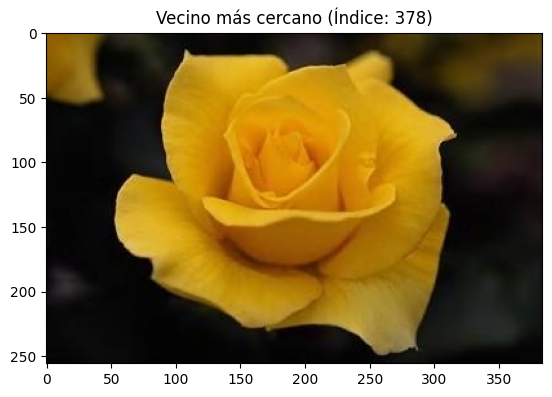

In [ ]:
index = read_index("ext_5.index")
print(f"Total de vectores en el índice: {index.ntotal}")

query_image_path = "dataset/test_set/monuments/208.jpg"
query_feature = extract_features(query_image_path).reshape(1, -1).astype("float32")
k = 4
distances, indices = search_faiss_index(index, query_feature, k)

print("Índices de los vecinos más cercanos:", indices)
print("Distancias de los vecinos más cercanos:", distances)